<a href="https://colab.research.google.com/github/pacesatuinineh/Gaussian-Blur/blob/main/CodeFarooq01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 128s 646ms/step - accuracy: 0.2230 - loss: 5.1307 - val_accuracy: 0.3048 - val_loss: 3.2496 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.3762 - loss: 2.8072 - val_accuracy: 0.2460 - val_loss: 2.6285 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.4287 - loss: 1.9010 - val_accuracy: 0.2674 - val_loss: 2.0466 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.4743 - loss: 1.5813 - val_accuracy: 0.4385 - val_loss: 1.8723 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.5224 - loss: 1.4056 - val_accuracy: 0.4144 - val_loss: 1.7725 - learning_rate: 0.0010
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5325 - loss: 1.3338 - val_accuracy: 0.4545 - val_loss: 1.5995 - learning_rate: 0.0010
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.5484 - loss: 1.2737

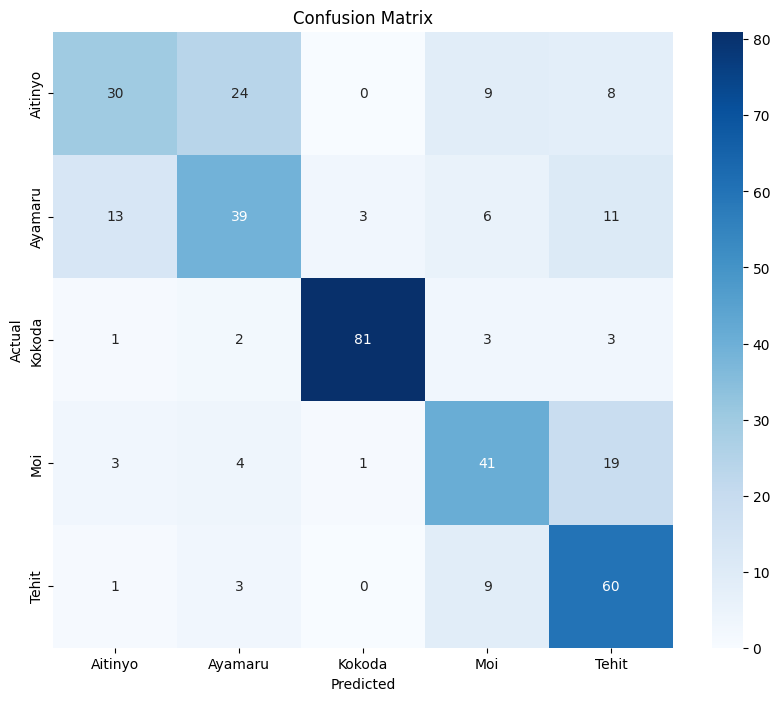

              precision    recall  f1-score   support

     Aitinyo       0.62      0.42      0.50        71
     Ayamaru       0.54      0.54      0.54        72
      Kokoda       0.95      0.90      0.93        90
         Moi       0.60      0.60      0.60        68
       Tehit       0.59      0.82      0.69        73

    accuracy                           0.67       374
   macro avg       0.66      0.66      0.65       374
weighted avg       0.68      0.67      0.67       374



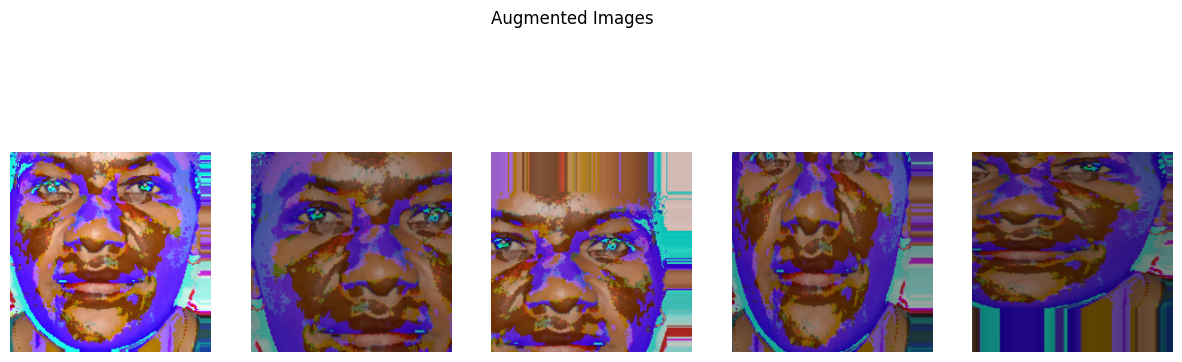

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path ke dataset
data_path = "/content/drive/MyDrive/modifdataset"  # Ganti sesuai lokasi dataset

# Parameter model dan training
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100

# Fungsi untuk memuat dan memproses dataset
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = cv2.resize(image, IMAGE_SIZE)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_and_preprocess_images(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Oversampling menggunakan SMOTE
images_flattened = images.reshape(len(images), -1)
smote = SMOTE(random_state=42)
images_resampled, labels_resampled = smote.fit_resample(images_flattened, labels_encoded)
images_resampled = images_resampled.reshape(-1, 224, 224, 3)
labels_resampled = to_categorical(labels_resampled)

# Split dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images_resampled, labels_resampled, test_size=0.2, random_state=42
)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weight_dict = dict(enumerate(class_weights))

# Data Augmentation
train_datagen = ImageDataGenerator(
    #rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5]
)
test_datagen = ImageDataGenerator()

# Model dengan EfficientNetB0
def build_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((224, 224, 3), labels_categorical.shape[1])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training model
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    validation_data=test_datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluasi Model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Visualisasi Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Laporan Klasifikasi
print(classification_report(true_classes, predicted_classes, target_names=encoder.classes_))

# Visualisasi Augmentasi Data
def visualize_augmentation(image):
    augmented_images = [train_datagen.random_transform(image) for _ in range(5)]
    plt.figure(figsize=(15, 5))
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(cv2.cvtColor(aug_img.astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.suptitle("Augmented Images")
    plt.show()

# Visualisasi gambar pertama
visualize_augmentation(train_images[5])
